In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import tensorflow as tf
#import tensorflow.keras.backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import MaxPool2D
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
import numpy as np
np.random.seed(0)
import itertools
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
from google.colab import files #add .json file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
import zipfile
import os
from kaggle.cli import main
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d harshart/dataset-alpha2

100% 1.16G/1.16G [00:59<00:00, 23.3MB/s]
100% 1.16G/1.16G [00:59<00:00, 20.9MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('dataset-alpha2.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
data_dir = r"/tmp/Dataset alpha2"

train_dir = data_dir + "/training"
valid_dir = data_dir + "/valid"

In [ ]:
seed_train_validation = 1 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0.2

train_gen = tf.keras.utils.image_dataset_from_directory(
                                                        directory = train_dir,
                                                        image_size = (128, 128),
                                                        label_mode='categorical',
                                                        validation_split = validation_split,
                                                        batch_size=32,
                                                        subset = "training",
                                                        seed = seed_train_validation,
                                                        shuffle = shuffle_value)

val_gen = tf.keras.utils.image_dataset_from_directory(
                                                        directory = train_dir,
                                                        image_size = (128, 128),
                                                        validation_split = validation_split,
                                                        label_mode='categorical',
                                                        batch_size=32,
                                                        subset = "validation",
                                                        seed = seed_train_validation,
                                                        shuffle = shuffle_value)

test_it = tf.keras.utils.image_dataset_from_directory( directory= valid_dir,
                                                      batch_size=32,
                                                      image_size=(128, 128))

Found 60930 files belonging to 9 classes.
Using 48744 files for training.
Found 60930 files belonging to 9 classes.
Using 12186 files for validation.
Found 15231 files belonging to 9 classes.


In [ ]:
rescale = Rescaling(scale=1./255)
train_set  = train_gen.map(lambda image,label:(rescale(image),label))
valid_set  = val_gen.map(lambda image,label:(rescale(image),label))
test_set  = test_it.map(lambda image,label:(rescale(image),label))

In [ ]:
filepath = '/content/my_best_plant_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                     monitor='val_loss',
                                     verbose=1,
                                     save_best_only=True,
                                     save_weights_only=False,
                                     mode='auto',
                                     save_freq='epoch')


In [ ]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
#val_Accuracy = 97.4 and Accuracy = 99.1 with 128 filters
#---------------------------------------------------------------#
#Test Accuracy= 96.82% Test Loss= 24.62% with 64 filters

# define cnn model
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(64, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(9, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
model = define_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it);teststeps=len(test_it)
# fit model
history = model.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=epochs, verbose=1)
test_loss, test_acc = model.evaluate(test_it, steps=teststeps, verbose=1)
print('Test Accuracy=',str(test_acc * 100.0)+'%')
print('Test Loss=',str(test_loss*100)+'%')

Epoch 1/10
1524/1524 [==============================] - 148s 91ms/step - loss: 1.7344 - accuracy: 0.6053 - val_loss: 0.7270 - val_accuracy: 0.7703
Epoch 2/10
1524/1524 [==============================] - 113s 74ms/step - loss: 0.5462 - accuracy: 0.8225 - val_loss: 0.4569 - val_accuracy: 0.8493
Epoch 3/10
1524/1524 [==============================] - 116s 76ms/step - loss: 0.3394 - accuracy: 0.8887 - val_loss: 0.3463 - val_accuracy: 0.9161
Epoch 4/10
1524/1524 [==============================] - 113s 74ms/step - loss: 0.2523 - accuracy: 0.9392 - val_loss: 0.3278 - val_accuracy: 0.9154
Epoch 5/10
1524/1524 [==============================] - 115s 75ms/step - loss: 0.1903 - accuracy: 0.9545 - val_loss: 0.2250 - val_accuracy: 0.9432
Epoch 6/10
1524/1524 [==============================] - 115s 76ms/step - loss: 0.1573 - accuracy: 0.9632 - val_loss: 0.2196 - val_accuracy: 0.9465
Epoch 7/10
1524/1524 [==============================] - 120s 79ms/step - loss: 0.1178 - accuracy: 0.9719 - val_loss: 0

In [ ]:
plt.plot(lr_schedule(history))

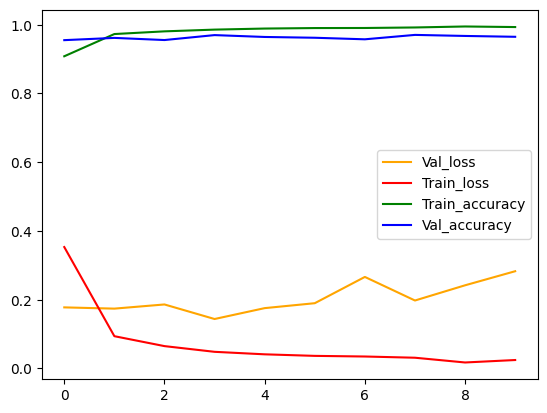

In [ ]:
plt.plot(history.history['val_loss'], color = 'orange')
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['accuracy'], color = 'green')
plt.plot(history.history['val_accuracy'], color = 'blue')
plt.legend(['Val_loss','Train_loss','Train_accuracy','Val_accuracy'])

Own CNN

In [ ]:
#Val_Accuracy = 97.78 & Accuracy = 99.43 with 128 Dense filters C->BN->MPool x 3  F+D+BN+D
#Val_Accuracy = 98.23 & Accuracy = 99.10 with 128 Dense filters C->BN->MPool x 3  F+D+BN+Drop+D
#Val_Accuracy = 96.88 & Accuracy = 99.60 with 128 Dense filters C->Mpool->BN x 3  F+D+BN+D
# ------------------------------------------------------------------------------------------------------- #
#Test Accuracy= 96.507 & Test Loss= 12.18 with 64 Dense filters C->Mpool->BN x 3  F+D+BN+Drop0.5+D
#Test Accuracy= 96.815 & Test Loss= 11.60 with 64 Dense filters C->Mpool->BN x 3  F+D+BN+D
#Test Accuracy= 96.586 & Test Loss= 11.92 with 64 Dense filters C->BN->MPool x 3  F+D+BN+D
#Test Accuracy= 95.016 & Test Loss= 16.56 with 64 Dense filters C->BN->MPool x 3  F+D+BN+Drop0.5+D
#Test Accuracy= 96.224 & Test Loss= 12.52 with 128 Dense filters C->Mpool->BN x 3  F+D+BN+D
#-------------------------------------------------------------------------------------------------------- #
#Test Accuracy= 97.971 & Test Loss= 7.64 with 128 Dense filters C->Mpool->BN x 3  F+D+BN+D ---- 15 epochs
#Test Accuracy= 97.564 & Test Loss= 9.38 with  64 Dense filters C->Mpool->BN x 3  F+D+BN+D ---- 15 epochs


classifier = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding="same", input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64,(3,3),padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

#Fully conected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation ="relu"),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation= "softmax")
])

In [ ]:
#all = define_all()
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it);teststeps=len(test_it)
# fit model
history = classifier.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=epochs, callbacks=callbacks, verbose=1)
test_loss, test_acc = classifier.evaluate(test_it, steps=teststeps, verbose=1)
print('Test Accuracy=',str(test_acc * 100.0)+'%')
print('Test Loss=',str(test_loss*100)+'%')

Epoch 1/10
1524/1524 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.8696 - precision: 0.9091 - recall: 0.8340
Epoch 1: val_loss improved from inf to 0.18687, saving model to /content
1524/1524 [==============================] - 121s 71ms/step - loss: 0.4019 - accuracy: 0.8696 - precision: 0.9091 - recall: 0.8340 - val_loss: 0.1869 - val_accuracy: 0.9397 - val_precision: 0.9527 - val_recall: 0.9293
Epoch 2/10
1524/1524 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9598 - precision: 0.9665 - recall: 0.9539
Epoch 2: val_loss improved from 0.18687 to 0.17187, saving model to /content
1524/1524 [==============================] - 109s 72ms/step - loss: 0.1226 - accuracy: 0.9598 - precision: 0.9665 - recall: 0.9539 - val_loss: 0.1719 - val_accuracy: 0.9428 - val_precision: 0.9488 - val_recall: 0.9371
Epoch 3/10
1523/1524 [============================>.] - ETA: 0s - loss: 0.0777 - accuracy: 0.9732 - precision: 0.9765 - recall: 0.9705
Epoch 3: 

ValueError: ignored

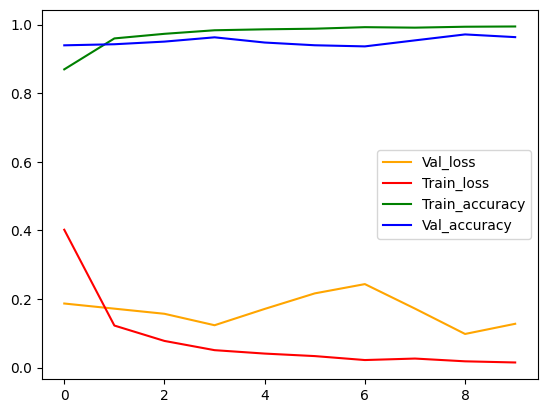

In [ ]:
plt.plot(history.history['val_loss'], color = 'orange')
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['accuracy'], color = 'green')
plt.plot(history.history['val_accuracy'], color = 'blue')
plt.legend(['Val_loss','Train_loss','Train_accuracy','Val_accuracy'])

In [ ]:
classifier.save('Own_Flat128_model10_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Test Accuracy= 97.813 & Test Loss= 6.63 with 128 Dense filters C->Mpool->BN x 3  F+D+BN+D
#Test Accuracy= 96.303 & Test Loss= 11.3 with 64 Dense filters C->Mpool->BN x 3  F+D+BN+D
#Test Accuracy= 97.104 & Test Loss= 9.02 with 64 Dense filters C->Mpool->BN x 3  F+D+BN+Drop+D
#-----------------------------------------------------------#
#Test Accuracy= 97.96 & Test Loss= 6.21 - precision: 0.9813 - recall: 0.978 with 64 Dense filters C->Mpool->BN x 3  F+D+BN+D  15 epochs
#Test Accuracy: 97.30 & Test loss: 8.62 - precision: 0.9748 - recall: 0.971 with 64 Dense filters C->Mpool->BN x 3  F+D+BN+Drop0.5+D  15 epochs
#Test Accuracy: 97.94 & Test loss: 6.41 - precision: 0.9817 - recall: 0.977 with 64 Dense filters C->Mpool->BN x 3  F+D+BN+D  20 epochs
#Test Accuracy: 98.35 & Test loss: 5.05 - precision: 0.9845 - recall: 0.982 with 128 Dense filters C->Mpool->BN x 3  F+D+BN+Drop+D 20 epochs
#Test Accuracy: 98.07 & Test loss: 6.26 - precision: 0.9813 - recall: 0.979 with 128 Dense filters C->Mpool->BN x 3  F+D+BN+D 20 epochs
#loss: 0.0411 - accuracy: 0.9864 - precision: 0.9872 - recall: 0.9857
#----------------------------------------------------------------------------------#
#loss: 1.4697 - accuracy: 0.6965  with 128 Dense filters C->Mpool->Drop0.5-0.6-0.7->BN x 3  F+D+BN+Drop0.6+D 15 epochs
#loss: 1.0666 - accuracy: 0.7773  with 128 Dense filters C->Mpool->Drop0.5-0.5-0.5->BN x 3  F+D+BN+Drop0.6+D 15 epochs



avg_classifier = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding="same", input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64,(3,3),padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

#Fully conected
    tf.keras.layers.GlobalAveragePooling2D(data_format=None, keepdims=False),
    tf.keras.layers.Dense(128, activation ="relu"),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(9, activation= "softmax")
])

In [ ]:
avg_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
avg_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
%%time
epochsteps=len(train_set);epochs =20;valsteps=len(valid_set);#teststeps=len(test_it)
# fit model
history = avg_classifier.fit(train_set, steps_per_epoch=epochsteps,
                            validation_data=valid_set, validation_steps=valsteps,
                            epochs=epochs, callbacks = callbacks, verbose=1)
# test_loss, test_acc = avg_classifier.evaluate(test_it, steps=teststeps, verbose=1)
# print('Test Accuracy=',str(test_acc * 100.0)+'%')
# print('Test Loss=',str(test_loss*100)+'%')

Epoch 1/20
1524/1524 [==============================] - ETA: 0s - loss: 0.5723 - accuracy: 0.8079
Epoch 1: val_loss improved from inf to 0.39990, saving model to /content/my_best_plant_model.epoch01-loss0.40.hdf5
1524/1524 [==============================] - 69s 36ms/step - loss: 0.5723 - accuracy: 0.8079 - val_loss: 0.3999 - val_accuracy: 0.8529
Epoch 2/20
1522/1524 [============================>.] - ETA: 0s - loss: 0.2287 - accuracy: 0.9216
Epoch 2: val_loss did not improve from 0.39990
1524/1524 [==============================] - 55s 36ms/step - loss: 0.2287 - accuracy: 0.9216 - val_loss: 0.9173 - val_accuracy: 0.7385
Epoch 3/20
1521/1524 [============================>.] - ETA: 0s - loss: 0.1440 - accuracy: 0.9513
Epoch 3: val_loss improved from 0.39990 to 0.34051, saving model to /content/my_best_plant_model.epoch03-loss0.34.hdf5
1524/1524 [==============================] - 53s 34ms/step - loss: 0.1442 - accuracy: 0.9511 - val_loss: 0.3405 - val_accuracy: 0.8768
Epoch 4/20
1522/1524

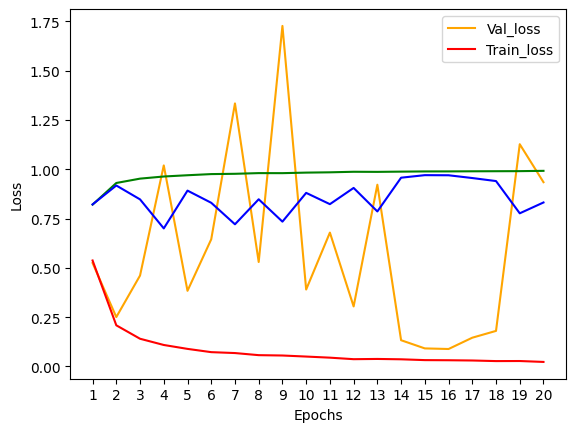

In [ ]:
plt.plot(history.history['val_loss'], color = 'orange')
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['accuracy'], color = 'green')
plt.plot(history.history['val_accuracy'], color = 'blue')
plt.legend(['Val_loss','Train_loss'])
e=range(0,20)
labels=range(1,21)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(e,labels)
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/my_best_plant_model.epoch16-loss0.09.hdf5')
#/content/my_best_plant_model.epoch16-loss0.09.hdf5)

In [ ]:
labels = []
predictions = []
for x,y in test_set:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 0s 118ms/step


In [ ]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [ ]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 99.20 %
Test Accuracy   : 97.01 %
Precision Score : 97.01 %
Recall Score    : 97.01 %


ValueError: ignored

<Figure size 200x200 with 0 Axes>

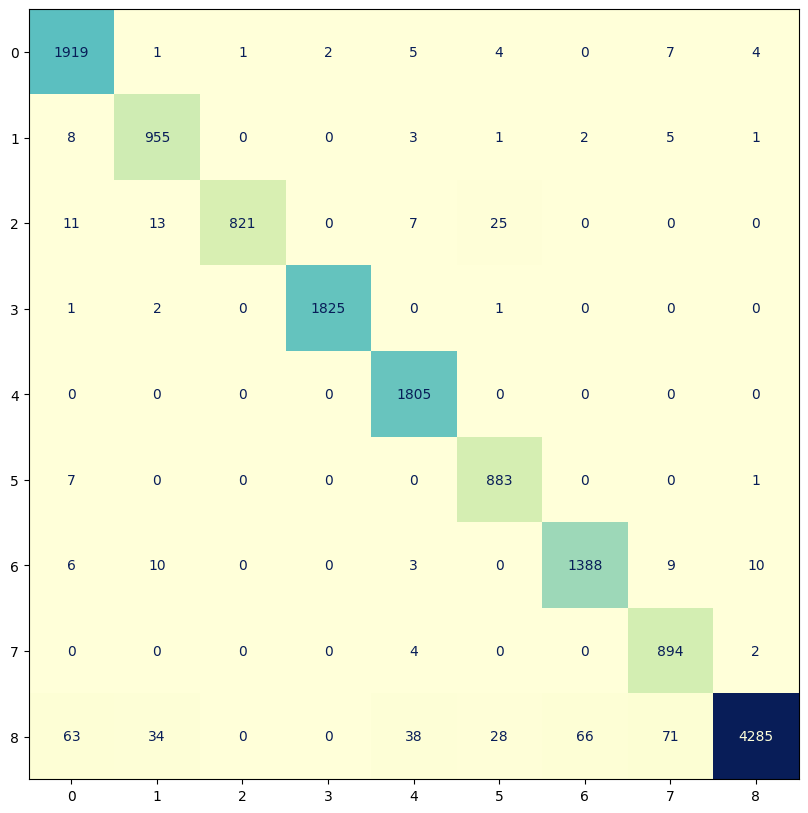

In [ ]:
# Plot a confusion matrix based on the true labels and predicted labels
plt.figure(figsize= (2,2))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1,9)))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
avg_classifier.save('Own_Avg128Drop_model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
filepath = '/content'

In [ ]:
model = keras.models.load_model(filepath)

OSError: ignored